In [ ]:
# Copyright (c) 2017 Max deGroot, Ellis Brown
# Released under the MIT license
# https://github.com/amdegroot/ssd.pytorch
# Updated by: Takuya Mouri

In [ ]:
# # バージョンを指定する場合、セルをコメントアウトしてください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install Pillow==5.0.0

In [1]:
# version確認
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.5.1+cu101
0.6.1+cu101


In [2]:
# GPUの接続
import torch
torch.cuda.is_available()

True

# Google Driveへのマウント（Colab利用時のみ）

In [3]:
# Google Driveにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My Drive/Colab Notebooks/pytorch_handbook/chapter7/demo

/content/gdrive/My Drive/Colab Notebooks/pytorch_handbook/chapter7/demo


In [5]:
# ファイル名を表示
!ls

__init__.py  sample2.jpg  sample.jpg  section7_1.ipynb	section7_9.ipynb


# 学習済みモデルのダウンロード（フォルダweightsに未格納の場合）

In [ ]:
# 学習済みモデルのパラメータファイルをダウンロード
!wget https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

--2019-03-08 14:33:22--  https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105151288 (100M) [application/x-www-form-urlencoded]
Saving to: ‘ssd300_mAP_77.43_v2.pth’

ssd300_mAP_77.43_v2 100%[===================>] 100.28M  44.9MB/s    in 2.2s    

2019-03-08 14:33:24 (44.9 MB/s) - ‘ssd300_mAP_77.43_v2.pth’ saved [105151288/105151288]



In [ ]:
# フォルダweights未作成の場合に作成
import os
if not os.path.exists('../weights/'):
    os.mkdir('../weights/')

In [ ]:
# 学習済みモデルをフォルダweightsに移動
!mv ssd300_mAP_77.43_v2.pth ../weights

# SSDネットワークの推論実行
##SSDの関連モジュールをimport

In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

## 引数testでネットワークを定義し、学習済みモデルをロード

In [7]:
# ネットワークの定義
# 引数が'test'だと、推論結果に対してクラスDetectで後処理を実行
ssd_net = build_ssd('test', 300, 21)    # initialize SSD

# GPUの場合、deviceに'cuda'を設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# GPUへの転送
net = ssd_net.to(device)

# 学習済みモデルのロード
net.load_weights('../weights/ssd300_mAP_77.43_v2.pth')
#net.load_weights('../weights/VOC.pth')

Loading weights into state dict...
Finished!


In [8]:
# ネットワークリストの表示
print(net)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## VOCから画像ファイルを取得

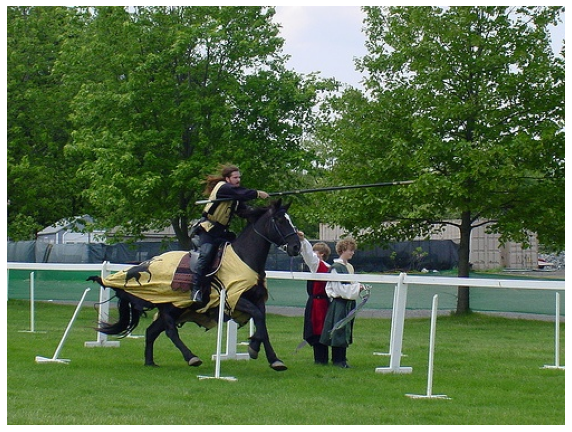

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
# 読込み画像ファイルの引数を'test'から'val'に変更 
# 本と同じ画像を表示する場合はsection7_4.ipynbで引数'test'のVOCデータをダウンロードすること
#testset = VOCDetection(VOC_ROOT, [('2007', 'test')], None, VOCAnnotationTransform())
testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
# クラスVOCDetectionはindexをキーに画像を取得する
img_id = 2
image = testset.pull_image(img_id)

# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

## 畳み込み計算できるよう前処理を実行

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


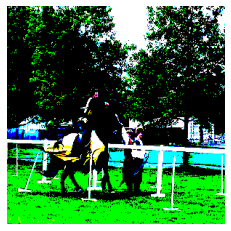

In [16]:
# 画像のサイズを300×300に変更
x = cv2.resize(image, (300, 300)).astype(np.float32)
# 平均のRGBを引く
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
x = x[:, :, ::-1].copy()
plt.axis('off')
plt.imshow(x)
# HWCの形状[300, 300, 3]をCHWの形状[3, 300,300]に変更
x = torch.from_numpy(x).permute(2, 0, 1)

## SSDネットワークの順伝播計算を実行

In [17]:
# 0次元目にバッチサイズの次元を追加
# [3, 300, 300]　→　[1, 3, 300, 300] 
xx = x.unsqueeze(0)
# GPUへの転送
xx = xx.to(device)
# dropoutを実行しない
net.eval()
# 計算グラフを作成しない
with torch.no_grad():
  # 順伝播を実行し、推論結果を出力
  y = net(xx)

## バウンディングボックスの出力

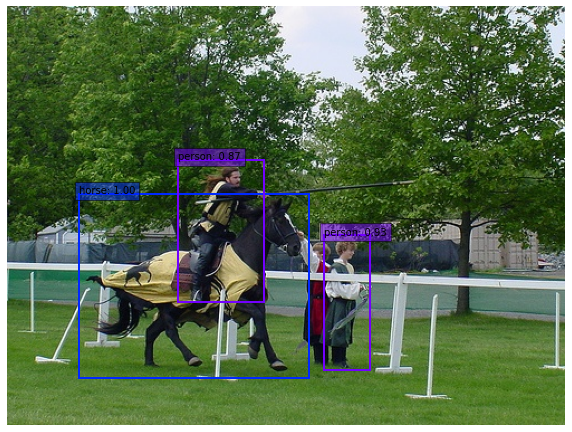

In [18]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.axis('off')
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# 推論結果をdetectionsに格納
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
# クラスiでループ
for i in range(detections.size(1)):
    j = 0
# 確信度confが0.6以上のボックスを表示
# jは確信度上位200件のボックスのインデックス
# detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [19]:
# 1次元目は画像ファイル数、2次元目はクラス、3次元目は確信度のトップ200件、4次元目は確信度+座標[conf,xmin,ymin,xmax,ymax]
detections.shape

torch.Size([1, 21, 200, 5])

In [20]:
# データセットVOCの20クラス
VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

In [21]:
# horseは13番号のクラス
detections[0][13]

tensor([[ 0.9999,  0.1271,  0.4460,  0.5382,  0.8833],
        [ 0.0740,  0.2683,  0.3878,  0.4781,  0.7555],
        [ 0.0501,  0.0026,  0.5110,  0.1961,  0.7191],
        [ 0.0339,  0.2242,  0.6866,  0.3695,  0.8728],
        [ 0.0266,  0.6644,  0.5131,  0.8742,  0.6866],
        [ 0.0172,  0.4513,  0.5200,  0.7209,  0.8843],
        [ 0.0161,  0.0882,  0.5560,  0.2788,  0.7634],
        [ 0.0149,  0.2767,  0.4803,  0.5446,  0.6311],
        [ 0.0135,  0.4645,  0.5102,  0.5583,  0.8573],
        [ 0.0133,  0.0437,  0.5447,  0.3204,  0.6819],
        [ 0.0130,  0.3538,  0.5463,  0.5977,  0.6794],
        [ 0.0129,  0.3552,  0.5961,  0.6041,  0.7304],
        [ 0.0124,  0.0073,  0.5822,  0.1784,  0.7982],
        [ 0.0115, -0.0124,  0.4882,  0.1461,  0.6400],
        [ 0.0104,  0.3940,  0.5005,  0.5271,  0.8689],
        [ 0.0104,  0.1526,  0.6907,  0.4645,  0.8633],
        [ 0.0104,  0.1860,  0.5372,  0.4702,  0.6870],
        [ 0.0103,  0.0179,  0.4317,  0.4016,  0.8036],
        [ 